Please enter the match id: 18402


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


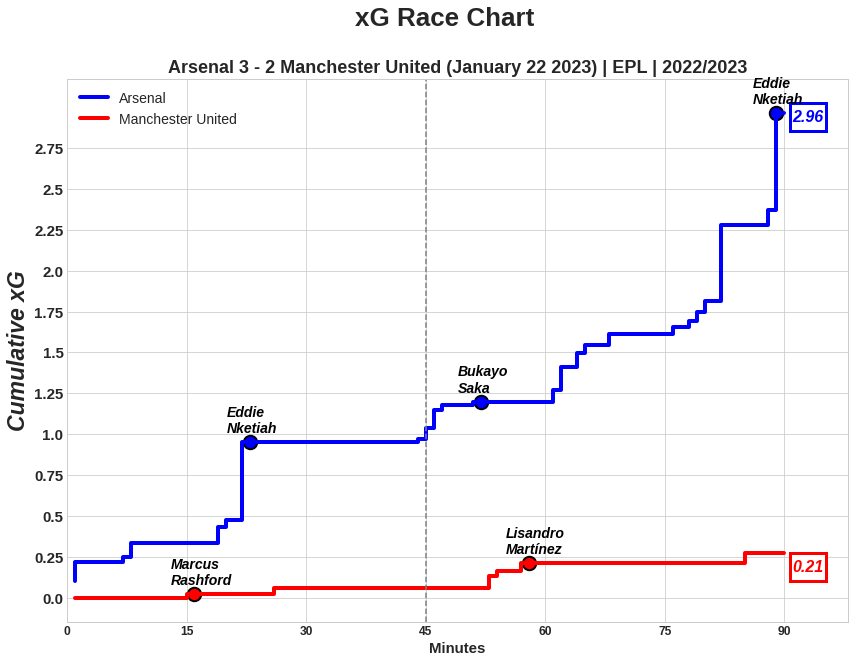

In [63]:
import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# This part includes web scraping from Understat
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url + match

req = requests.get(url)
parse_soup = soup(req.content, 'lxml')
scripts = parse_soup.find_all('script')

title = parse_soup.find('title').string
title = ' '.join(title.split()[:-4])

# get only shots data
strings = scripts[1].string

ind_start = strings.index("('") + 2
ind_end = strings.index("')")

json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)

# Saving the scraped data into dataframes
x = []
y = []
xg = []
team = []
minute = []
result = []
player = []
data_away = data['a']
data_home = data['h']

for index in range(len(data_home)):
    for key in data_home[index]:
        if key == 'xG':
            xg.append(data_home[index][key])
        if key == 'h_team':
            team.append(data_home[index][key])
        if key == 'minute':
            minute.append(data_home[index][key])
        if key == 'result':
            result.append(data_home[index][key])
        if key == 'player':
            player.append(data_home[index][key])

for index in range(len(data_away)):
    for key in data_away[index]:
        if key == 'xG':
            xg.append(data_away[index][key])
        if key == 'a_team':
            team.append(data_away[index][key])
        if key == 'minute':
            minute.append(data_away[index][key])
        if key == 'result':
            result.append(data_away[index][key])
        if key == 'player':
            player.append(data_away[index][key])

cols = ['minute', 'player', 'result', 'xg', 'team']
df = pd.DataFrame([minute, player, result, xg, team], index=cols)
df = df.T

# Creating a minute by minute dataframe
time = np.arange(1, 91, 1)
xg_data_home = pd.DataFrame(time)
xg_data_home.columns = ['minute']
xg_data_away = pd.DataFrame(time)
xg_data_away.columns = ['minute']

# Dividing original df into home and away and changing data types
team_lst = list(df['team'].unique())
df_home = df[df['team'] == team_lst[0]]
df_home[['minute', 'xg']] = df_home[['minute', 'xg']].apply(pd.to_numeric)
df_away = df[df['team'] == team_lst[1]]
df_away[['minute', 'xg']] = df_away[['minute', 'xg']].apply(pd.to_numeric)

# Merging the two dfs into one for both home and away
xg_data_home = pd.merge(xg_data_home, df_home, on='minute', how='left')
xg_data_home['xg'] = xg_data_home['xg'].fillna(0)
xg_data_home['team'] = xg_data_home['team'].fillna(team_lst[0])
xg_data_home['Cum xg'] = xg_data_home['xg'].cumsum()

xg_data_away = pd.merge(xg_data_away, df_away, on='minute', how='left')
xg_data_away['xg'] = xg_data_away['xg'].fillna(0)
xg_data_away['team'] = xg_data_away['team'].fillna(team_lst[1])
xg_data_away['Cum xg'] = xg_data_away['xg'].cumsum()

# Keeping a df only for goals data
home_goals = xg_data_away.loc[xg_data_away['result'] == 'Goal']
away_goals = xg_data_home.loc[xg_data_home['result'] == 'Goal']
goals = pd.concat([home_goals, away_goals])

ytick = max(xg_data_home.iloc[-1]['Cum xg'], xg_data_away.iloc[-1]['Cum xg'])
if ytick > 3:
    space = 0.5
else:
    space = 0.25
# Plotting the xG distribution graph
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 10))
plt.step(xg_data_home['minute'], xg_data_home['Cum xg'], label=team_lst[0],color='blue',linewidth=4)
plt.step(xg_data_away['minute'], xg_data_away['Cum xg'], label=team_lst[1],color='red',linewidth=4)
plt.xlabel("Minutes", fontsize=15, weight="bold")
plt.ylabel("Cumulative xG", fontsize=23, weight="bold",style='italic')
plt.suptitle('xG Race Chart', fontsize=26, weight="bold")
plt.title(title, fontsize=18, weight="bold")
plt.xlim(0, 98)
plt.axvline(45, ls='--', color='grey')
plt.xticks(np.arange(0, 91, 15),fontsize=12, fontweight='bold')
plt.yticks(np.arange(0, ytick, space))
plt.gca().set_yticklabels(plt.gca().get_yticks(), fontsize=15,fontweight='bold')

texts = []
for x, y, s in zip(np.array(goals['minute']), np.array(goals['Cum xg']), goals['player'].str.split()):
    texts.append(plt.text(x - 3, y+0.06 , s[0] +'\n' + s[1], fontdict=dict(color='black', size=14, style='italic', weight='bold')))


for j, k ,t in zip(np.array(goals['minute']), np.array(goals['Cum xg']),np.array(goals['team'])):
    if t == team_lst[0]:
      cor = 'blue'
    else:
      cor = 'red'
    plt.scatter(j, k,marker='o',s=180,c=cor,edgecolors='black',linewidths=2)


goals_team_a = goals[goals['team']==team_lst[0]]
goals_team_b = goals[goals['team']==team_lst[1]]

text_ = str(round(goals_team_a['Cum xg'].max(), 2))

rect = Rectangle((90.7,  float(goals_team_a['Cum xg'].max())-0.11), 4.5, 0.17, facecolor='white',edgecolor='blue', linewidth=3)
plt.gca().add_patch(rect)

rect1 = Rectangle((90.7,  float(goals_team_b['Cum xg'].max())-0.11), 4.5, 0.17, facecolor='white',edgecolor='red', linewidth=3)
plt.gca().add_patch(rect1)

plt.text(91, float(goals_team_a['Cum xg'].max())-0.05 , str(round(goals_team_a['Cum xg'].max(),2)), fontdict=dict(color='blue', size=16, style='italic', weight='bold'))
plt.text(91, float(goals_team_b['Cum xg'].max())-0.05 , str(round(goals_team_b['Cum xg'].max(),2)), fontdict=dict(color='red', size=16, style='italic', weight='bold'))


plt.legend(fontsize=14,
           frameon=False, facecolor='white')
plt.savefig('xg_viz.png',dpi=300,facecolor='white')
plt.show()

In [28]:
goals_team_a = goals[goals['team']==team_lst[0]]
max_xg_a_df = goals_team_a[goals_team_a['Cum xg']==goals_team_a['Cum xg'].max()]

In [29]:
max_xg_a_df

,minute,player,result,xg,team,Cum xg
93,89,Eddie Nketiah,Goal,0.589234,Arsenal,2.963627


In [25]:
goals.head()

,minute,player,result,xg,team,Cum xg
15,16,Marcus Rashford,Goal,0.020166,Manchester United,0.020166
57,58,Lisandro Martínez,Goal,0.047230,Manchester United,0.210401
22,23,Eddie Nketiah,Goal,0.477999,Arsenal,0.950185
53,52,Bukayo Saka,Goal,0.015839,Arsenal,1.197088
93,89,Eddie Nketiah,Goal,0.589234,Arsenal,2.963627
